# Multi Layer Perceptron

## Standard Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
%matplotlib inline

## Create Artificial Data

In [2]:
size = 200

zerone = pd.DataFrame()
zerone['x1']  = np.random.randint(0,2,size)
zerone['x2']  = np.random.randint(0,2,size)
zerone['And'] = np.logical_and(zerone.x1,zerone.x2)
zerone['Or']  = np.logical_or(zerone.x1,zerone.x2)
zerone['Xor'] = np.logical_xor(zerone.x1,zerone.x2)

zerone = zerone*1
a = zerone[['And','Or','Xor']].replace(0,-1)
zerone[['And','Or','Xor']] = a

zerone.head()

,x1,x2,And,Or,Xor
0,0,0,-1,-1,-1
1,1,1,1,1,-1
2,0,0,-1,-1,-1
3,0,1,-1,1,1
4,0,1,-1,1,1


## MLP2HL

In [3]:
class MLP2HL(object):
    
    def __init__(self, Xtrain, ytrain, Xval, yval, epochs, lr, n1, n2, precision):
        self.epc    = epochs
        self.lr     = lr
        self.n1     = n1   #First hidden layer neuron quantity
        self.n2     = n2
        
        self.d       = ytrain.values
        self.x       = np.insert(Xtrain.values, 0, -1, axis = 1)
        self.dval       = yval.values
        self.xval       = np.insert(Xval.values, 0, -1, axis = 1)
        
        self.mse_      = []
        self.mse       = pd.DataFrame()
        self.mseval_      = []
        self.mseval       = pd.DataFrame()
        
        
        self.precision = precision
        
        
        self.weight1 = np.random.rand(self.n1,self.x.shape[1])  
        self.weight2 = np.random.rand(self.n2,self.n1+1)          #+1 for the w0
        self.weight3 = np.random.rand(self.d.shape[1],self.n2+1)  #+1 for the w0
        
        self.sigma1 = np.zeros(self.n1)
        self.sigma2 = np.zeros(self.n2)
        self.sigma3 = np.zeros(self.d.shape[1])
        
        self.scape = False
        
        #Activations functions and it's derivates
    def tanh(self, val):
        return np.tanh(val)
    
    def tanhD(self, val):
        return (1-(np.tanh(val))**2)
    
    def logistic(self, val):
        return (1/(1+np.exp(-val)))
    
    def logisticD(self, val):
        aux = (1/(1+np.exp(-val)))
        return aux*(1-aux)
      
    #Forward step 
    def forward(self):        
        self.l1 = np.dot(self.xi,self.weight1.T)
        self.Y1 = np.insert(self.tanh(self.l1), 0, -1)
        self.l2 = np.dot(self.Y1,self.weight2.T)
        self.Y2 = np.insert(self.tanh(self.l2), 0, -1)
        self.l3 = np.dot(self.Y2, self.weight3.T)
        self.Y3 = self.tanh(self.l3)
        
    def backpropagation(self):
        #Step 1
        self.sigma3    = ((self.di - self.Y3)*self.tanhD(self.l3))
        self.sigma3    =  self.sigma3.reshape(-1,1)
        self.weight3  +=   self.lr*self.sigma3*self.Y2
        
        #Step 2
        ## Layer 2
        self.sigma2   = np.sum(self.sigma3*self.weight3[:,1:], axis=0)*self.tanhD(self.l2)
        self.sigma2   = self.sigma2.reshape(-1,1)
        self.weight2 += (self.lr*self.sigma2*self.Y1)
        
        ## Layer 1
        self.sigma1   =  np.sum(self.sigma2*self.weight2[:,1:], axis=0)*self.tanhD(self.l1)
        self.sigma1   =  self.sigma1.reshape(-1,1)
        self.weight1 += (self.lr*self.sigma1*self.xi)
        
        
        

    def predict(self,x,act_func):   
        self.pred_x = np.insert(x, 0, -1, axis = 1)
        self.pred = []
        for xi in self.pred_x:
            self.xi = xi
            self.forward()
            self.pred.append(self.Y2)
        
        if act_func == 'None':
            return self.pred
        
        elif act_func == 'Step':
            return self.step(self.pred)
        
        elif act_func == 'biStep':
            return self.biStep(self.pred)
    
    def MSE(self,train_val):
        
        if train_val == 'train':
            error    = np.square(self.mse_)/2
            error    = error.mean()
            error    = pd.DataFrame([error])
            self.mse = pd.concat((self.mse,error))
        
        elif train_val == 'val':
            error       = np.array(mlp.mseval_)/2
            error       = error.mean()
            error       = pd.DataFrame([error])
            self.mseval = pd.concat((self.mseval,error))
        
    def validation(self):
        self.mseval_ = []
        for xi,di in zip(self.xval,self.dval):
            self.xi = xi
            self.di = di
            self.forward()
            error = (self.dval-self.Y3)**2
            self.mseval_.append(np.sum(error))   
            
        self.MSE('val')
    
    
    def fit(self):
        self.iteration = 0
        while(self.scape == False):
            self.mse_    = []
            for xi,di in zip(self.x,self.d):
                self.xi = xi
                self.di = di
                self.forward()
                self.backpropagation()
                error = (self.di-self.Y3)**2
                self.mse_.append(np.sum(error))
                
                
            self.MSE('train')
            self.validation()
            
            self.iteration += 1
            if self.iteration >= self.epc:
                self.scape = True
                
            if self.iteration > 1:
                self.e = np.absolute(self.mse.iloc[-1][0] - self.mse.iloc[-2][0])
                
                if (self.precision >= self.e):   
                    self.scape = True
    
    def step(self, y):
        return (pd.DataFrame(y)>=0)*1
    
    def biStep(self, y):
        return ((pd.DataFrame(y)>=0)*1).replace(0,-1)    

## MLP1HL

In [318]:
class MLP1HL(object):
    
    def __init__(self, Xtrain, ytrain, Xval, yval, Xtest, ytest, epochs, lr, n1, precision, alpha):
        self.epc    = epochs
        self.lr     = lr
        self.n1     = n1   #First hidden layer neuron quantity
        
        self.d       = ytrain.values
        self.x       = np.insert(Xtrain.values, 0, -1, axis = 1)
        self.dval    = yval.values
        self.xval    = np.insert(Xval.values, 0, -1, axis = 1)
        self.xtest   = np.insert(Xtest, 0, -1, axis = 1)
        self.dtest   = ytest.values
        
        self.mse_      = []
        self.mse       = pd.DataFrame()
        self.mseval_   = []
        self.mseval    = pd.DataFrame()
        self.msetest_  = []
        self.msetest   = pd.DataFrame()
        self.minmseval = 100000
        
        
        self.precision = precision
        
        
        self.weight1 = np.random.rand(self.n1,self.x.shape[1])  
        self.weight2 = np.random.rand(self.d.shape[1],self.n1+1)          #+1 for the w0
        self.weight1_t_1 = self.weight1
        self.weight2_t_1 = self.weight2
        self.alpha = alpha
        
        self.scape = False

        
        #Activations functions and it's derivates
    def tanh(self, val):
        return np.tanh(val)
    
    def tanhD(self, val):
        return (1-(np.tanh(val))**2)
    
    def logistic(self, val):
        return (1/(1+np.exp(-val)))
    
    def logisticD(self, val):
        aux = (1/(1+np.exp(-val)))
        return aux*(1-aux)
      
    #Forward step 
    def forward(self):        
        self.l1 = np.dot(self.xi,self.weight1.T)
        self.Y1 = np.insert(self.tanh(self.l1), 0, -1)
        self.l2 = np.dot(self.Y1, self.weight2.T)
        self.Y2 = self.tanh(self.l2)
        
    def backpropagation(self):
        #Step 1
        self.sigma2    = ((self.di - self.Y2)*self.tanhD(self.l2))
        self.sigma2    =  self.sigma2.reshape(-1,1)
        self.weight2  +=   (self.lr*self.sigma2*self.Y1)+(self.alpha*(self.weight2-self.weight2_t_1))
        self.weight2_t_1 = self.weight2
        
        #Step 2
        ## Layer 1
        self.sigma1  =  np.sum(self.sigma2*self.weight2[:,1:], axis=0)*self.tanhD(self.l1)
        self.sigma1  =  self.sigma1.reshape(-1,1)
        self.weight1 += (self.lr*self.sigma1*self.xi)+(self.alpha*(self.weight1-self.weight1_t_1))
        self.weight1_t_1 = self.weight1

    def predict(self,x,act_func):   
        self.pred_x = np.insert(x, 0, -1, axis = 1)
        self.pred = []
        for xi in self.pred_x:
            self.xi = xi
            self.forward()
            self.pred.append(self.Y2)
        
        if act_func == 'None':
            return self.pred
        
        elif act_func == 'Step':
            return self.step(self.pred)
        
        elif act_func == 'biStep':
            return self.biStep(self.pred)
        
    
    def validation(self):
        self.mseval_ = []
        for xi,di in zip(self.xval,self.dval):
            self.xi = xi
            self.di = di
            self.forward()
            error = np.square((self.di-self.Y2)
            self.mseval_.append(np.sum(error))   
            
        self.MSE('val')
        
        
    def predict_test(self):
        self.msetest_ = []
        for xi,di in zip(self.xtest,self.dtest):
            self.xi    = xi
            self.di    = di
            self.forward()
            error = np.square((self.di-self.Y2)
            self.msetest_.append(np.sum(error))
        
        self.MSE('test')
        
    
    def MSE(self,train_val):
        
        if train_val == 'train':
            error    = np.array(self.mse_)/2
            error    = error.mean()
            error    = pd.DataFrame([error])
            self.mse = pd.concat((self.mse,error))
        
        elif train_val == 'val':
            error       = np.array(mlp.mseval_)/2
            error       = error.mean()
            error       = pd.DataFrame([error])
            self.mseval = pd.concat((self.mseval,error))
            
        elif train_val == 'test':
            error        = np.array(mlp.msetest_)/2
            error        = error.mean()
            error        = pd.DataFrame([error])
            self.msetest = pd.concat((self.msetest,error))
    
    
    def fit(self):
        self.iteration = 0
        while(self.scape == False):
            self.mse_    = []
            for xi,di in zip(self.x,self.d):
                self.xi = xi
                self.di = di
                self.forward()
                self.backpropagation()
                error = np.square(self.di-self.Y2)
                self.mse_.append(np.sum(error))
                
                
            self.MSE('train')
            self.validation()
            
            
            self.iteration += 1
            if self.iteration >= self.epc:
                self.scape = True
                
            if self.iteration > 1:
                #Stop criteria
                self.e = np.absolute(self.mse.iloc[-1][0] - self.mse.iloc[-2][0])
                
                if (self.precision >= self.e):   
                    self.scape = True
                
                #Best weight saving
                if (self.mseval.iloc[-1][0] < self.minmseval):
                    self.minmseval = self.mseval.iloc[-1][0]
                    self.best_w1   = self.weight1
                    self.best_w2   = self.weight2
                    self.ite_check = self.iteration
            
        self.weight1 = self.best_w1
        self.weight2 = self.best_w2
        
        self.predict_test()
    
    def step(self, y):
        return (pd.DataFrame(y)>=0)*1
    
    def biStep(self, y):
        return ((pd.DataFrame(y)>=0)*1).replace(0,-1)

SyntaxError: invalid syntax (<ipython-input-318-deff9bb6a8d0>, line 96)

In [317]:
np.square(np.array([-1, 2, -3]))

array([1, 4, 9], dtype=int32)

In [8]:
sep = 100
X_train = zerone.iloc[:sep,:2]
y_train = zerone.iloc[:sep,2:]
X_test = zerone.iloc[sep:,:2]
y_test = zerone.iloc[sep:,2:]

### Portas lógicas

In [9]:
y_train_run = pd.DataFrame(y_train['Xor'])

In [39]:
weight1_mlp = pd.DataFrame()
weight2_mlp = pd.DataFrame()
mse_mlp     = pd.DataFrame(np.zeros(1000))
ite_mlp     = []

for i in np.arange(1,11,1):
    mlp = MLP1HL(Xtrain=X_train, ytrain=y_train_run, lr=0.001, epochs=1000, n1=3, precision = 0.00001)
    mlp.fit()
    mse_mlp[np.str(i)] = mlp.mse.reset_index()[0]
    ite_mlp.append(mlp.iteration)
    weight1_mlp = pd.concat((weight1_mlp,pd.DataFrame(mlp.weight1)))
    weight2_mlp = pd.concat((weight2_mlp,pd.DataFrame(mlp.weight2)))

mse_mlp.drop(0, axis = 1, inplace = True)
mse_mlp.dropna(axis=0, how='all')

NameError: name 'X_train' is not defined

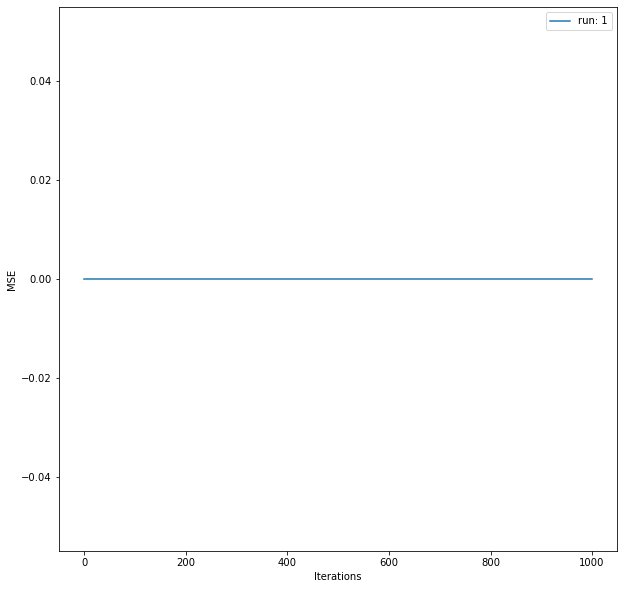

In [11]:
plt.figure(figsize = (10,10))
for i in range(mse_mlp.shape[1]):
    x = np.arange(0,mse_mlp.shape[0],1)
    plt.plot(x,mse_mlp.iloc[:,i], label='run: '+np.str(i+1))
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend(loc='best')

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

In [114]:
y = mlp.predict(X_test.values, act_func = 'biStep')

print(classification_report(y_test['Xor'],y))
print('\n')
print(confusion_matrix(y_test['Xor'],y))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        43

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



[[57  0]
 [ 0 43]]


#### Parâmetros

lr=0.001, epochs=1000, precision = 0.00001

##### AND

n=1
[531, 537, 543, 572, 540, 559, 569, 574, 567, 566]

run 3 mse: 0.0037040636790026467

n=2
[499, 518, 479, 471, 492, 468, 539, 505, 489, 486]

run 6 mse: 0.0034324181386589255

n=3
[446, 480, 437, 422, 442, 476, 502, 424, 470, 501]

run 5 mse: 0.003308679867185873

#### OR

n=1
[445, 453, 415, 430, 493, 452, 455, 468, 436, 431]

run 1 mse:0.0032915613370687402

n=2
[428, 367, 412, 386, 376, 408, 403, 406, 383, 418]

run 2 mse: 0.0029011203584703603

n=3
[347, 308, 367, 333, 375, 375, 350, 342, 371, 357]

run 2 mse: 0.002740870735822879

##### XOR

n=1
[926, 86, 929, 1000, 55, 1000, 965, 1000, 1000, 979]

run 1 mse: 0.33182229895002324

n=2
[1000, 996, 92, 1000, 1000, 1000, 1000, 921, 1000, 993]

run 10 mse: 0.005663927227978598

n=3
[939, 904, 944, 921, 1000, 1000, 949, 885, 1000, 905]

run 10 mse: 0.005229562458754368

## IRIS AND WINE

### Data loading and normalizing

In [6]:
def norm(x):
    xmin = x.min()
    xmax = x.max()
    x = np.array(x)
    x = -1 + (2*((x-xmin)/(xmax-xmin)))
    return x

In [7]:
from sklearn.datasets import load_iris, load_wine

In [8]:
iris = load_iris()
wine = load_wine()

In [9]:
iris_df = pd.DataFrame(data=iris.data,columns=iris.feature_names)
iris_df[iris.target_names] = pd.get_dummies(iris.target).astype(np.int).replace(0,-1)
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),setosa,versicolor,virginica
0,5.1,3.5,1.4,0.2,1,-1,-1
1,4.9,3.0,1.4,0.2,1,-1,-1
2,4.7,3.2,1.3,0.2,1,-1,-1
3,4.6,3.1,1.5,0.2,1,-1,-1
4,5.0,3.6,1.4,0.2,1,-1,-1


In [10]:
iris_df_norm = pd.DataFrame(data=iris.data,columns=iris.feature_names).apply(norm, axis=0, result_type='broadcast',raw=True)
iris_df_norm[iris.target_names] = pd.get_dummies(iris.target).astype(np.int).replace(0,-1)
iris_df_norm.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),setosa,versicolor,virginica
0,-0.555556,0.250000,-0.864407,-0.916667,1,-1,-1
1,-0.666667,-0.166667,-0.864407,-0.916667,1,-1,-1
2,-0.777778,0.000000,-0.898305,-0.916667,1,-1,-1
3,-0.833333,-0.083333,-0.830508,-0.916667,1,-1,-1
4,-0.611111,0.333333,-0.864407,-0.916667,1,-1,-1


In [11]:
wine_df = pd.DataFrame(data=wine.data,columns=wine.feature_names)
wine_df[wine.target_names] = pd.get_dummies(wine.target).astype(np.int).replace(0,-1)
wine_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class_0,class_1,class_2
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,1,-1,-1
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,1,-1,-1
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,1,-1,-1
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,1,-1,-1
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,1,-1,-1


In [12]:
wine_df_norm = pd.DataFrame(data=wine.data,columns=wine.feature_names).apply(norm, axis=0, result_type='broadcast',raw=True)
wine_df_norm[wine.target_names] = pd.get_dummies(wine.target).astype(np.int).replace(0,-1)
wine_df_norm.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class_0,class_1,class_2
0,0.684211,-0.616601,0.144385,-0.484536,0.239130,0.255172,0.147679,-0.433962,0.186120,-0.255973,-0.089431,0.941392,0.122682,1,-1,-1
1,0.142105,-0.588933,-0.165775,-0.938144,-0.347826,0.151724,0.021097,-0.509434,-0.451104,-0.470990,-0.073171,0.560440,0.101284,1,-1,-1
2,0.121053,-0.359684,0.401070,-0.175258,-0.326087,0.255172,0.223629,-0.358491,0.514196,-0.249147,-0.105691,0.391941,0.293866,1,-1,-1
3,0.757895,-0.521739,0.219251,-0.360825,-0.065217,0.979310,0.329114,-0.584906,0.116719,0.112628,-0.382114,0.597070,0.714693,1,-1,-1
4,0.163158,-0.268775,0.614973,0.072165,0.043478,0.255172,-0.008439,-0.018868,-0.110410,-0.481229,-0.089431,0.216117,-0.348074,1,-1,-1


In [13]:
from sklearn.model_selection import train_test_split

In [19]:
# Spliting the indexes, because there are two different dataframes, normalized and not normalized

#Iris
Xtrain_iris_i, Xvaltest_iris_i, ytrain_iris_i, yvaltest_iris_i = train_test_split(range(iris_df.shape[0]),range(iris_df.shape[0]),
                                                    test_size=0.3)

Xtest_iris_i, Xval_iris_i, ytest_iris_i, yval_iris_i = train_test_split(Xvaltest_iris_i,yvaltest_iris_i,
                                                    test_size=0.5)


### Training and Assessment

### IRIS

In [20]:
Xtrain_iris = iris_df_norm[iris.feature_names].iloc[Xtrain_iris_i]
ytrain_iris = iris_df_norm[iris.target_names].iloc[ytrain_iris_i]
Xval_iris   = iris_df_norm[iris.feature_names].iloc[Xval_iris_i]
yval_iris   = iris_df_norm[iris.target_names].iloc[yval_iris_i]

In [21]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, classification_report

In [22]:
Xtest_iris = iris_df_norm[iris.feature_names].iloc[Xtest_iris_i].values
ytest_iris = iris_df_norm[iris.target_names].iloc[ytest_iris_i]
ytest_iris.replace(-1,0,inplace=True)

In [23]:
print('Dados treino:')
print(np.str(ytrain_iris.replace(-1,0).sum()))
print('\nDados validação:')
print(np.str(yval_iris.replace(-1,0).sum()))
print('\nDados teste:')
print(np.str(ytest_iris.sum()))

Dados treino:
setosa        33
versicolor    33
virginica     39
dtype: int64

Dados validação:
setosa        9
versicolor    9
virginica     5
dtype: int64

Dados teste:
setosa        8
versicolor    8
virginica     6
dtype: int64


n1 = 1:
lr = 0.001
precision = 0.0001
alpha=0.0001
epc = 1000

n1 = 3:
lr = 0.001
precision = 0.0001
alpha=0.0001
epc = 1000

n1 = 5:
lr = 0.001
precision = 0.0001
alpha=0.0001
epc = 1000

Dados treino:
setosa        36
versicolor    36
virginica     33
dtype: int64

Dados validação:
setosa        6
versicolor    8
virginica     9
dtype: int64

Dados teste:
setosa        8
versicolor    6
virginica     8
dtype: int64

#### 1 Hidden Layers

###### 1 neuron

In [320]:
epc          = 1000
mse_mlp      = pd.DataFrame(np.zeros(epc))
mseval_mlp   = pd.DataFrame(np.zeros(epc))
msetest_mlp_ = []
ite_mlp      = []
cla_report   = []

for i in np.arange(1,11,1):
    mlp = MLP1HL(Xtrain=Xtrain_iris, ytrain=ytrain_iris, Xval=Xval_iris, yval=yval_iris, Xtest= Xtest_iris, ytest=ytest_iris,
                 lr=0.05, epochs=epc, n1=1, precision = 0.00001 ,alpha=0.01)
    mlp.fit()
    
    mse_mlp[np.str(i)]     = mlp.mse.reset_index()[0]
    mseval_mlp[np.str(i)]  = mlp.mseval.reset_index()[0]
    msetest_mlp_.append(mlp.msetest.values[0][0])
    
    ite_mlp.append(mlp.iteration)
    
    y = pd.DataFrame(mlp.predict(Xtest_iris, act_func='biStep').values,columns=iris.target_names)
    y.replace(-1,0,inplace=True)
    cla_report = np.append(cla_report,classification_report(y_true=ytest_iris, y_pred=y))
    print('Run: '+np.str(i))
    
msetest_mlp = pd.DataFrame(msetest_mlp_)
mse_mlp.drop(0, axis = 1, inplace = True);
mse_mlp.dropna(axis=0, how='all',inplace=True);
mseval_mlp.drop(0, axis = 1, inplace = True);
mseval_mlp.dropna(axis=0, how='all',inplace=True);

C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run: 1


C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run: 2


C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run: 3


C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run: 4


C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run: 5


C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run: 6


C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run: 7


C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run: 8


C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run: 9
Run: 10


C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [321]:
for i in range(10):
    print('RUN: '+np.str(i)+'-------------------------------------------------------------------------')
    print(cla_report[i])

RUN: 0-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.00      0.00      0.00         8
           2       0.86      1.00      0.92         6

   micro avg       0.93      0.64      0.76        22
   macro avg       0.62      0.67      0.64        22
weighted avg       0.60      0.64      0.62        22
 samples avg       0.64      0.64      0.64        22

RUN: 1-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.00      0.00      0.00         8
           2       0.86      1.00      0.92         6

   micro avg       0.93      0.64      0.76        22
   macro avg       0.62      0.67      0.64        22
weighted avg       0.60      0.64      0.62        22
 samples avg       0.64  

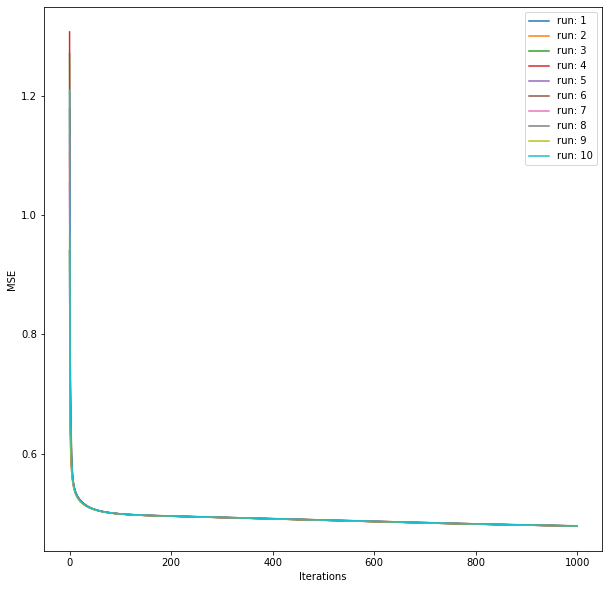

In [322]:
plt.figure(figsize = (10,10))
for i in range(mse_mlp.shape[1]):
    x = np.arange(0,mse_mlp.shape[0],1)
    plt.plot(x,mse_mlp.iloc[:,i], label='run: '+np.str(i+1))
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend(loc='best')

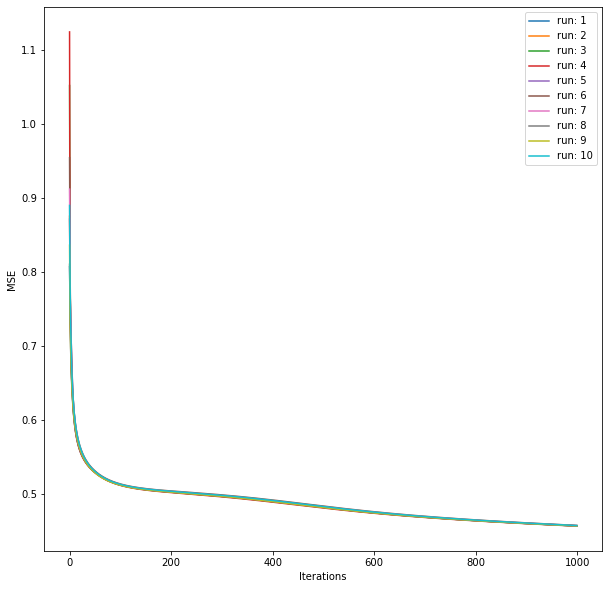

In [323]:
plt.figure(figsize = (10,10))
for i in range(mseval_mlp.shape[1]):
    x = np.arange(0,mseval_mlp.shape[0],1)
    plt.plot(x,mseval_mlp.iloc[:,i], label='run: '+np.str(i+1))
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend(loc='best')

In [324]:
msemin   = mseval_mlp.min().min()
minval   = mseval_mlp.iloc[:,(mseval_mlp.iloc[(mseval_mlp <= msemin).values] == msemin).values[0]]
mintrain = pd.DataFrame(mse_mlp[minval.columns[0]])
index = minval[minval.values == msemin].index[0]
msemin

0.4564181153528125

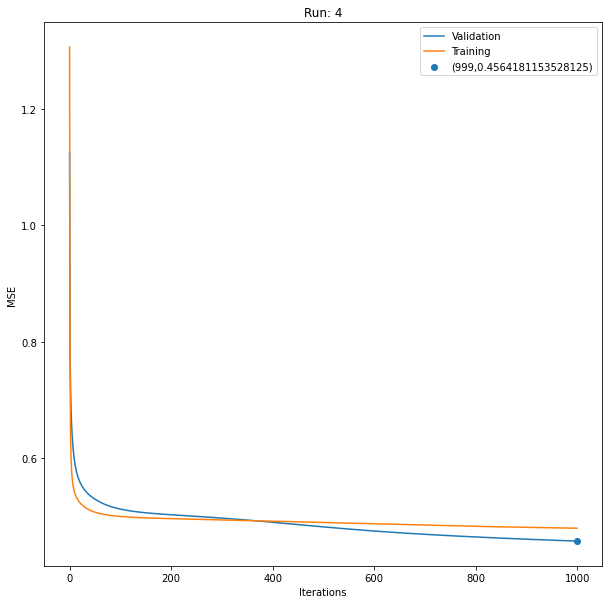

In [325]:
plt.figure(figsize = (10,10))

x = np.arange(0,minval.shape[0],1)
plt.plot(x,minval, label='Validation')
plt.plot(x,mintrain, label='Training')
plt.scatter(index,msemin)
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title('Run: '+minval.columns[0])
plt.legend(('Validation','Training','('+np.str(index)+','+np.str(msemin)+')'),loc='best')

Text(0, 0.5, 'MSE')

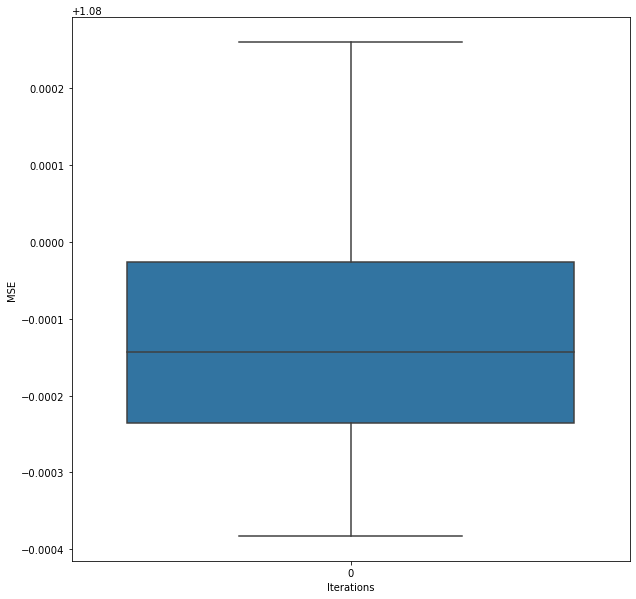

In [326]:
plt.figure(figsize = (10,10))
sns.boxplot(data=msetest_mlp)
plt.xlabel('Iterations')
plt.ylabel('MSE')

###### 3 Neurons

In [263]:
epc          = 1000
mse_mlp      = pd.DataFrame(np.zeros(epc))
mseval_mlp   = pd.DataFrame(np.zeros(epc))
msetest_mlp_ = []
ite_mlp      = []
cla_report   = []

for i in np.arange(1,11,1):
    mlp = MLP1HL(Xtrain=Xtrain_iris, ytrain=ytrain_iris, Xval=Xval_iris, yval=yval_iris, Xtest= Xtest_iris, ytest=ytest_iris,
                 lr=0.05, epochs=epc, n1=3, precision = 0.00001 ,alpha=0.01)
    mlp.fit()
    
    mse_mlp[np.str(i)]     = mlp.mse.reset_index()[0]
    mseval_mlp[np.str(i)]  = mlp.mseval.reset_index()[0]
    msetest_mlp_.append(mlp.msetest.values[0][0])
    
    ite_mlp.append(mlp.iteration)
    
    y = pd.DataFrame(mlp.predict(Xtest_iris, act_func='biStep').values,columns=iris.target_names)
    y.replace(-1,0,inplace=True)
    cla_report = np.append(cla_report,classification_report(y_true=ytest_iris, y_pred=y))
    print('Run: '+np.str(i))
    
msetest_mlp = pd.DataFrame(msetest_mlp_)
mse_mlp.drop(0, axis = 1, inplace = True);
mse_mlp.dropna(axis=0, how='all',inplace=True);
mseval_mlp.drop(0, axis = 1, inplace = True);
mseval_mlp.dropna(axis=0, how='all',inplace=True);

Run: 1
Run: 2
Run: 3
Run: 4
Run: 5
Run: 6
Run: 7
Run: 8
Run: 9
Run: 10


In [264]:
for i in range(10):
    print('RUN: '+np.str(i)+'-------------------------------------------------------------------------')
    print(cla_report[i])

RUN: 0-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         6

   micro avg       1.00      1.00      1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22
 samples avg       1.00      1.00      1.00        22

RUN: 1-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         6

   micro avg       1.00      1.00      1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22
 samples avg       1.00  

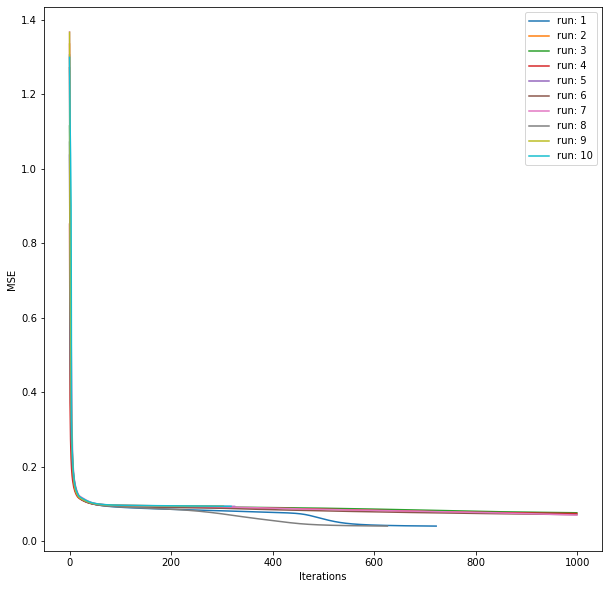

In [265]:
plt.figure(figsize = (10,10))
for i in range(mse_mlp.shape[1]):
    x = np.arange(0,mse_mlp.shape[0],1)
    plt.plot(x,mse_mlp.iloc[:,i], label='run: '+np.str(i+1))
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend(loc='best')

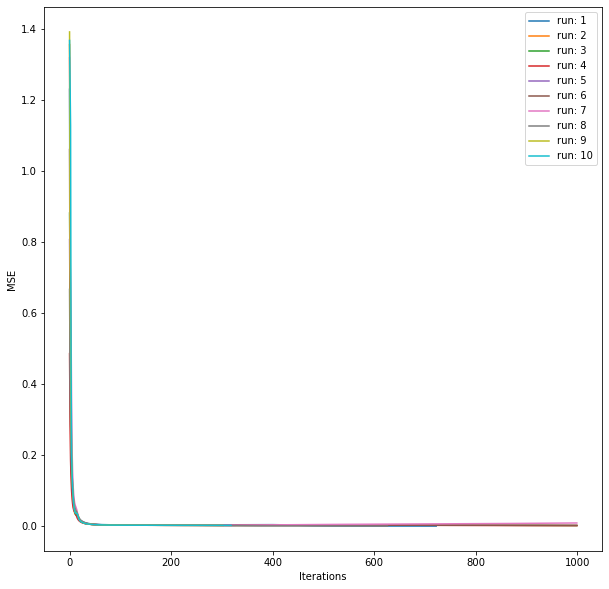

In [266]:
plt.figure(figsize = (10,10))
for i in range(mseval_mlp.shape[1]):
    x = np.arange(0,mseval_mlp.shape[0],1)
    plt.plot(x,mseval_mlp.iloc[:,i], label='run: '+np.str(i+1))
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend(loc='best')

In [267]:
msemin   = mseval_mlp.min().min()
minval   = mseval_mlp.iloc[:,(mseval_mlp.iloc[(mseval_mlp <= msemin).values] == msemin).values[0]]
mintrain = pd.DataFrame(mse_mlp[minval.columns[0]])
index = minval[minval.values == msemin].index[0]
msemin

0.000163555857117403

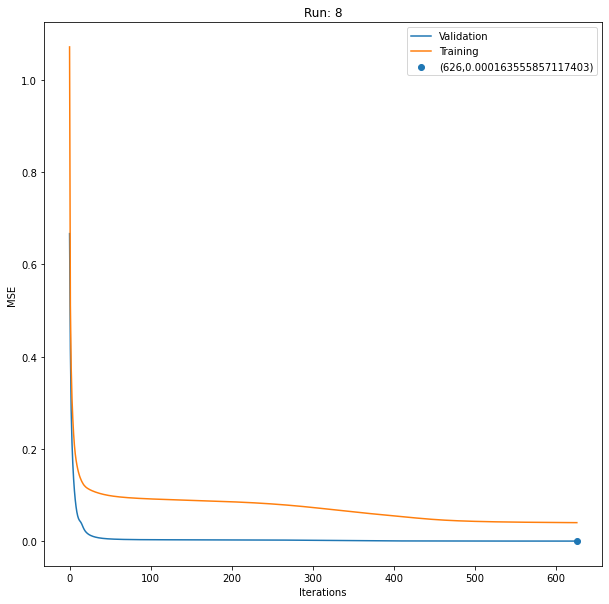

In [268]:
plt.figure(figsize = (10,10))

x = np.arange(0,minval.shape[0],1)
plt.plot(x,minval, label='Validation')
plt.plot(x,mintrain, label='Training')
plt.scatter(index,msemin)
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title('Run: '+minval.columns[0])
plt.legend(('Validation','Training','('+np.str(index)+','+np.str(msemin)+')'),loc='best')

Text(0, 0.5, 'MSE')

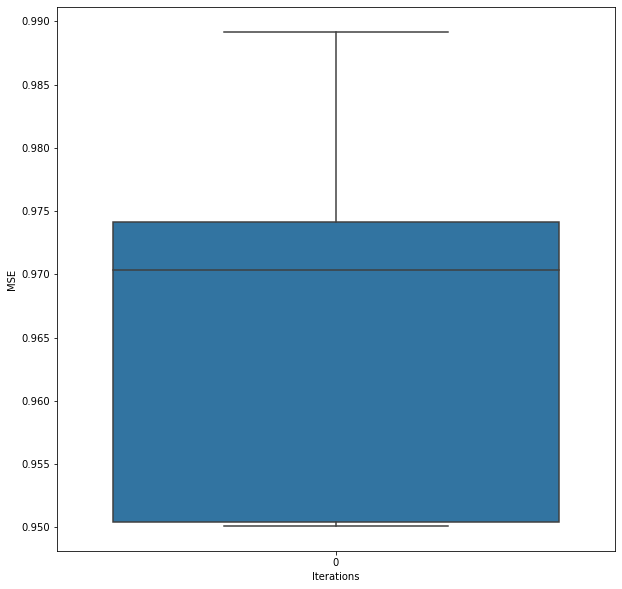

In [269]:
plt.figure(figsize = (10,10))
sns.boxplot(data=msetest_mlp)
plt.xlabel('Iterations')
plt.ylabel('MSE')

###### 5 Neurons

In [277]:
epc          = 1000
mse_mlp      = pd.DataFrame(np.zeros(epc))
mseval_mlp   = pd.DataFrame(np.zeros(epc))
msetest_mlp_ = []
ite_mlp      = []
cla_report   = []

for i in np.arange(1,11,1):
    mlp = MLP1HL(Xtrain=Xtrain_iris, ytrain=ytrain_iris, Xval=Xval_iris, yval=yval_iris, Xtest= Xtest_iris, ytest=ytest_iris,
                 lr=0.05, epochs=epc, n1=5, precision = 0.00001 ,alpha=0.01)
    mlp.fit()
    
    mse_mlp[np.str(i)]     = mlp.mse.reset_index()[0]
    mseval_mlp[np.str(i)]  = mlp.mseval.reset_index()[0]
    msetest_mlp_.append(mlp.msetest.values[0][0])
    
    ite_mlp.append(mlp.iteration)
    
    y = pd.DataFrame(mlp.predict(Xtest_iris, act_func='biStep').values,columns=iris.target_names)
    y.replace(-1,0,inplace=True)
    cla_report = np.append(cla_report,classification_report(y_true=ytest_iris, y_pred=y))
    print('Run: '+np.str(i))
    
msetest_mlp = pd.DataFrame(msetest_mlp_)
mse_mlp.drop(0, axis = 1, inplace = True);
mse_mlp.dropna(axis=0, how='all',inplace=True);
mseval_mlp.drop(0, axis = 1, inplace = True);
mseval_mlp.dropna(axis=0, how='all',inplace=True);

Run: 1
Run: 2
Run: 3
Run: 4
Run: 5
Run: 6
Run: 7
Run: 8
Run: 9
Run: 10


In [278]:
for i in range(10):
    print('RUN: '+np.str(i)+'-------------------------------------------------------------------------')
    print(cla_report[i])

RUN: 0-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      0.88      0.93         8
           2       0.86      1.00      0.92         6

   micro avg       0.95      0.95      0.95        22
   macro avg       0.95      0.96      0.95        22
weighted avg       0.96      0.95      0.95        22
 samples avg       0.95      0.95      0.95        22

RUN: 1-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      0.88      0.93         8
           2       0.86      1.00      0.92         6

   micro avg       0.95      0.95      0.95        22
   macro avg       0.95      0.96      0.95        22
weighted avg       0.96      0.95      0.95        22
 samples avg       0.95  

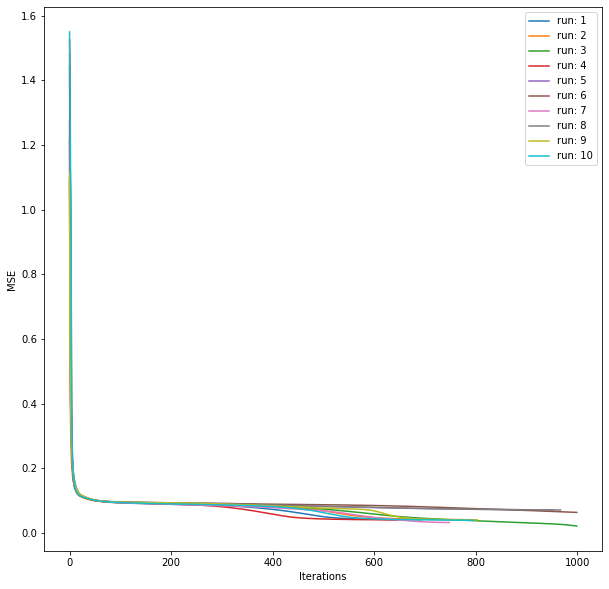

In [279]:
plt.figure(figsize = (10,10))
for i in range(mse_mlp.shape[1]):
    x = np.arange(0,mse_mlp.shape[0],1)
    plt.plot(x,mse_mlp.iloc[:,i], label='run: '+np.str(i+1))
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend(loc='best')

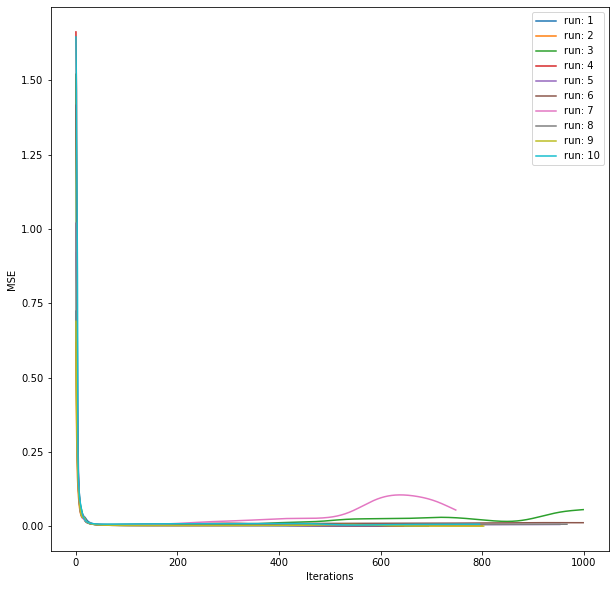

In [280]:
plt.figure(figsize = (10,10))
for i in range(mseval_mlp.shape[1]):
    x = np.arange(0,mseval_mlp.shape[0],1)
    plt.plot(x,mseval_mlp.iloc[:,i], label='run: '+np.str(i+1))
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend(loc='best')

In [281]:
msemin   = mseval_mlp.min().min()
minval   = mseval_mlp.iloc[:,(mseval_mlp.iloc[(mseval_mlp <= msemin).values] == msemin).values[0]]
mintrain = pd.DataFrame(mse_mlp[minval.columns[0]])
index = minval[minval.values == msemin].index[0]
msemin

0.0001473787655873403

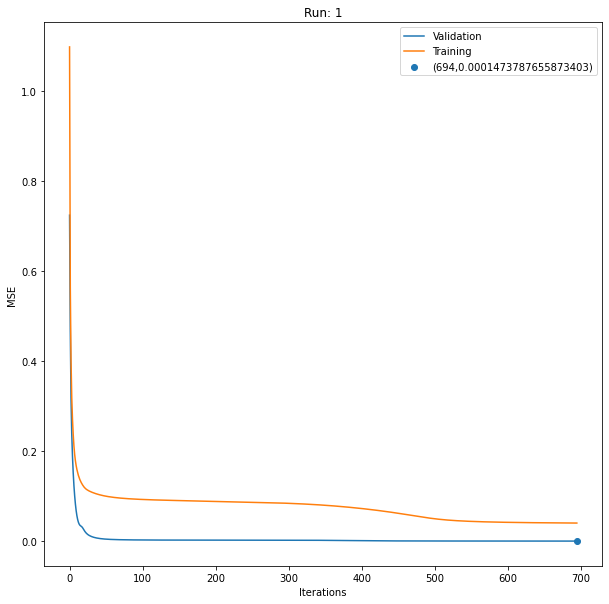

In [282]:
plt.figure(figsize = (10,10))

x = np.arange(0,minval.shape[0],1)
plt.plot(x,minval, label='Validation')
plt.plot(x,mintrain, label='Training')
plt.scatter(index,msemin)
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title('Run: '+minval.columns[0])
plt.legend(('Validation','Training','('+np.str(index)+','+np.str(msemin)+')'),loc='best')

Text(0, 0.5, 'MSE')

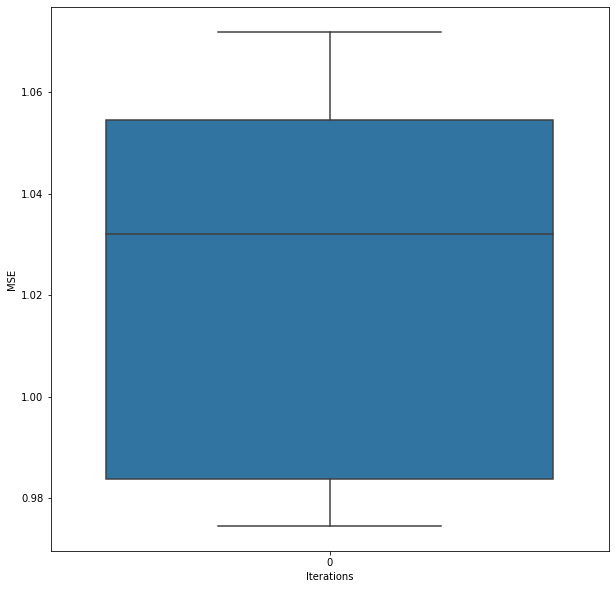

In [283]:
plt.figure(figsize = (10,10))
sns.boxplot(data=msetest_mlp)
plt.xlabel('Iterations')
plt.ylabel('MSE')

### WINE

In [116]:
Xtrain_wine_i, Xvaltest_wine_i, ytrain_wine_i, yvaltest_wine_i = train_test_split(range(wine_df.shape[0]),range(wine_df.shape[0]),
                                                    test_size=0.3)

Xtest_wine_i, Xval_wine_i, ytest_wine_i, yval_wine_i = train_test_split(Xvaltest_iris_i,yvaltest_iris_i,
                                                    test_size=0.5)

In [117]:
Xtrain_wine = wine_df_norm[wine.feature_names].iloc[Xtrain_wine_i]
ytrain_wine = wine_df_norm[wine.target_names].iloc[ytrain_wine_i]
Xval_wine   = wine_df_norm[wine.feature_names].iloc[Xval_wine_i]
yval_wine   = wine_df_norm[wine.target_names].iloc[yval_wine_i]

In [118]:
Xtest_wine = wine_df_norm[wine.feature_names].iloc[Xtest_wine_i].values
ytest_wine = wine_df_norm[wine.target_names].iloc[ytest_wine_i]
ytest_wine.replace(-1,0,inplace=True)

In [119]:
print('Dados treino:')
print(np.str(ytrain_wine.replace(-1,0).sum()))
print('\nDados validação:')
print(np.str(yval_wine.replace(-1,0).sum()))
print('\nDados teste:')
print(np.str(ytest_wine.sum()))

Dados treino:
class_0    42
class_1    47
class_2    35
dtype: int64

Dados validação:
class_0    10
class_1    11
class_2     2
dtype: int64

Dados teste:
class_0    10
class_1    10
class_2     2
dtype: int64


n1 = 1:
lr = 0.001
precision = 0.00001
alpha=0.00001
epc = 1000

n1 = 10:
lr = 0.001
precision = 0.00001
alpha=0.00001
epc = 1000

n1 = 15:
lr = 0.005
precision = infy
alpha=0.0005
epc = 1000

Dados treino:
class_0    38
class_1    54
class_2    32
dtype: int64

Dados validação:
class_0     9
class_1    11
class_2     3
dtype: int64

Dados teste:
class_0     8
class_1    11
class_2     3

###### 1 Neuron

In [328]:
epc          = 1000
mse_mlp      = pd.DataFrame(np.zeros(epc))
mseval_mlp   = pd.DataFrame(np.zeros(epc))
msetest_mlp_ = []
ite_mlp      = []
cla_report   = []

for i in np.arange(1,11,1):
    mlp = MLP1HL(Xtrain=Xtrain_wine, ytrain=ytrain_wine, Xval=Xval_wine, yval=yval_wine, Xtest=Xtest_wine, ytest=ytest_wine,
                 lr=0.01, epochs=epc, n1=1, precision = 0.00001, alpha=0.01)
    mlp.fit()
    mse_mlp[np.str(i)] = mlp.mse.reset_index()[0]
    mseval_mlp[np.str(i)] = mlp.mseval.reset_index()[0]
    msetest_mlp_.append(mlp.msetest.values[0][0])
    
    ite_mlp.append(mlp.iteration)
    
    y = pd.DataFrame(mlp.predict(Xtest_wine, act_func='biStep').values,columns=wine.target_names)
    y.replace(-1,0,inplace=True)
    
    cla_report = np.append(cla_report,classification_report(y_true=ytest_wine, y_pred=y))
    print('Run: '+np.str(i))
    
msetest_mlp = pd.DataFrame(msetest_mlp_)
mse_mlp.drop(0, axis = 1, inplace = True);
mse_mlp.dropna(axis=0, how='all',inplace=True);
mseval_mlp.drop(0, axis = 1, inplace = True);
mseval_mlp.dropna(axis=0, how='all',inplace=True);

C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run: 1


C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run: 2


C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run: 3


C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run: 4


C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run: 5


C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run: 6


C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run: 7


C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run: 8


C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run: 9
Run: 10


C:\Users\thiag\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [329]:
for i in range(10):
    print('RUN: '+np.str(i)+'-------------------------------------------------------------------------')
    print(cla_report[i])

RUN: 0-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.50      0.20      0.29        10
           2       1.00      1.00      1.00         2

   micro avg       0.88      0.64      0.74        22
   macro avg       0.83      0.73      0.76        22
weighted avg       0.77      0.64      0.68        22
 samples avg       0.59      0.64      0.61        22

RUN: 1-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.50      0.20      0.29        10
           2       1.00      1.00      1.00         2

   micro avg       0.88      0.64      0.74        22
   macro avg       0.83      0.73      0.76        22
weighted avg       0.77      0.64      0.68        22
 samples avg       0.59  

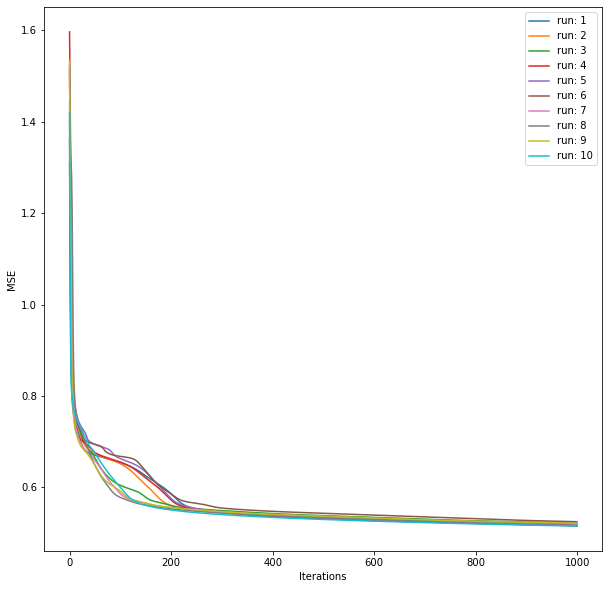

In [330]:
plt.figure(figsize = (10,10))
for i in range(mse_mlp.shape[1]):
    x = np.arange(0,mse_mlp.shape[0],1)
    plt.plot(x,mse_mlp.iloc[:,i], label='run: '+np.str(i+1))
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend(loc='best')

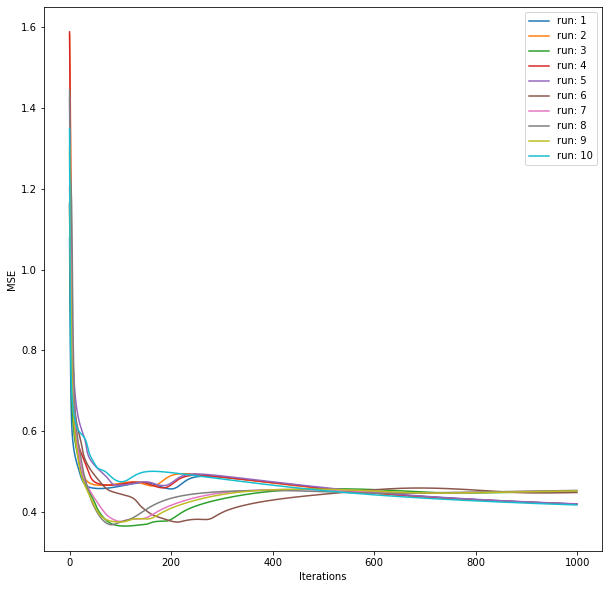

In [331]:
plt.figure(figsize = (10,10))
for i in range(mseval_mlp.shape[1]):
    x = np.arange(0,mseval_mlp.shape[0],1)
    plt.plot(x,mseval_mlp.iloc[:,i], label='run: '+np.str(i+1))
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend(loc='best')

In [332]:
msemin   = mseval_mlp.min().min()
minval   = mseval_mlp.iloc[:,(mseval_mlp.iloc[(mseval_mlp <= msemin).values] == msemin).values[0]]
mintrain = pd.DataFrame(mse_mlp[minval.columns[0]])
index = minval[minval.values == msemin].index[0]
msemin

0.36495854253777

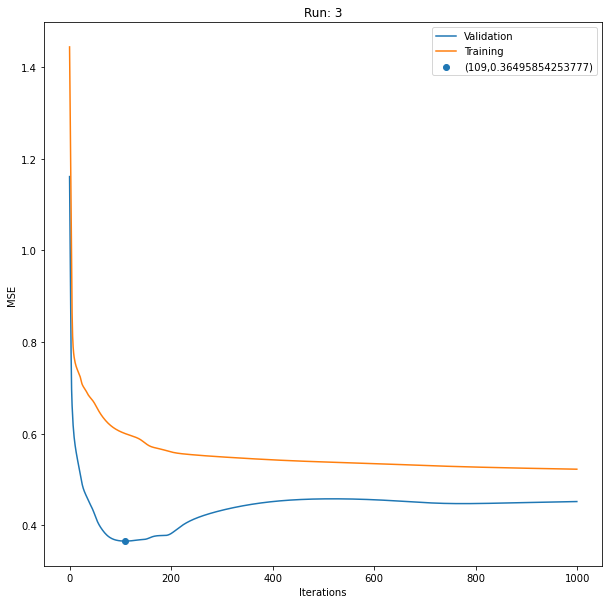

In [333]:
plt.figure(figsize = (10,10))

x = np.arange(0,minval.shape[0],1)
plt.plot(x,minval, label='Validation')
plt.plot(x,mintrain, label='Training')
plt.scatter(index,msemin)
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title('Run: '+minval.columns[0])
plt.legend(('Validation','Training','('+np.str(index)+','+np.str(msemin)+')'),loc='best')

Text(0, 0.5, 'MSE')

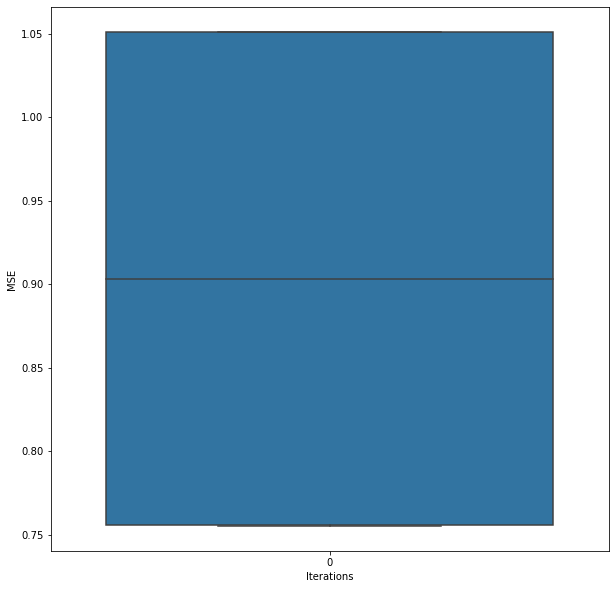

In [334]:
plt.figure(figsize = (10,10))
sns.boxplot(data=msetest_mlp)
plt.xlabel('Iterations')
plt.ylabel('MSE')

###### 3 Neurons

In [292]:
epc          = 1000
mse_mlp      = pd.DataFrame(np.zeros(epc))
mseval_mlp   = pd.DataFrame(np.zeros(epc))
msetest_mlp_ = []
ite_mlp      = []
cla_report   = []

for i in np.arange(1,11,1):
    mlp = MLP1HL(Xtrain=Xtrain_wine, ytrain=ytrain_wine, Xval=Xval_wine, yval=yval_wine, Xtest=Xtest_wine, ytest=ytest_wine,
                 lr=0.05, epochs=epc, n1=3, precision =0.00001, alpha=0.01)
    mlp.fit()
    mse_mlp[np.str(i)] = mlp.mse.reset_index()[0]
    mseval_mlp[np.str(i)] = mlp.mseval.reset_index()[0]
    msetest_mlp_.append(mlp.msetest.values[0][0])
    
    ite_mlp.append(mlp.iteration)
    
    y = pd.DataFrame(mlp.predict(Xtest_wine, act_func='biStep').values,columns=wine.target_names)
    y.replace(-1,0,inplace=True)
    
    cla_report = np.append(cla_report,classification_report(y_true=ytest_wine, y_pred=y))
    print('Run: '+np.str(i))
    
msetest_mlp = pd.DataFrame(msetest_mlp_)
mse_mlp.drop(0, axis = 1, inplace = True);
mse_mlp.dropna(axis=0, how='all',inplace=True);
mseval_mlp.drop(0, axis = 1, inplace = True);
mseval_mlp.dropna(axis=0, how='all',inplace=True);

Run: 1
Run: 2
Run: 3
Run: 4
Run: 5
Run: 6
Run: 7
Run: 8
Run: 9
Run: 10


In [293]:
for i in range(10):
    print('RUN: '+np.str(i)+'-------------------------------------------------------------------------')
    print(cla_report[i])

RUN: 0-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         2

   micro avg       1.00      1.00      1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22
 samples avg       1.00      1.00      1.00        22

RUN: 1-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         2

   micro avg       1.00      1.00      1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22
 samples avg       1.00  

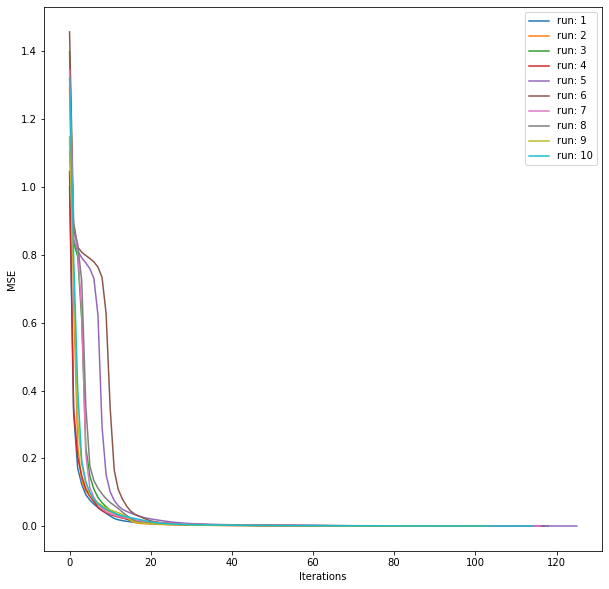

In [294]:
plt.figure(figsize = (10,10))
for i in range(mse_mlp.shape[1]):
    x = np.arange(0,mse_mlp.shape[0],1)
    plt.plot(x,mse_mlp.iloc[:,i], label='run: '+np.str(i+1))
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend(loc='best')

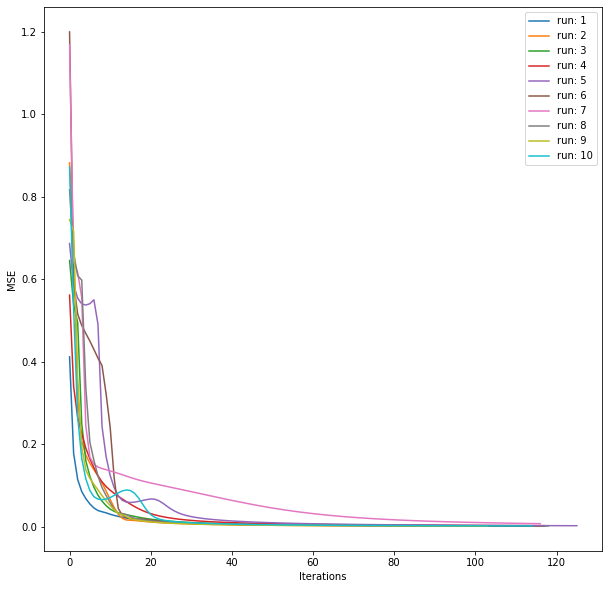

In [295]:
plt.figure(figsize = (10,10))
for i in range(mseval_mlp.shape[1]):
    x = np.arange(0,mseval_mlp.shape[0],1)
    plt.plot(x,mseval_mlp.iloc[:,i], label='run: '+np.str(i+1))
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend(loc='best')

In [296]:
msemin   = mseval_mlp.min().min()
minval   = mseval_mlp.iloc[:,(mseval_mlp.iloc[(mseval_mlp <= msemin).values] == msemin).values[0]]
mintrain = pd.DataFrame(mse_mlp[minval.columns[0]])
index = minval[minval.values == msemin].index[0]
msemin

0.0014126471554820952

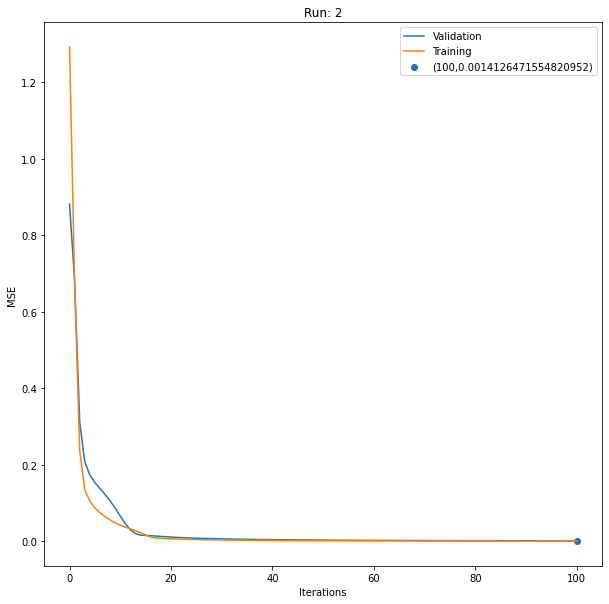

In [297]:
plt.figure(figsize = (10,10))

x = np.arange(0,minval.shape[0],1)
plt.plot(x,minval, label='Validation')
plt.plot(x,mintrain, label='Training')
plt.scatter(index,msemin)
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title('Run: '+minval.columns[0])
plt.legend(('Validation','Training','('+np.str(index)+','+np.str(msemin)+')'),loc='best')

Text(0, 0.5, 'MSE')

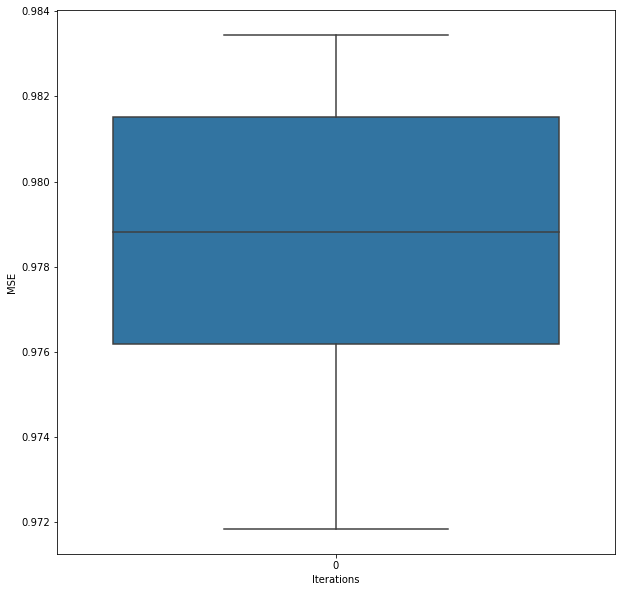

In [298]:
plt.figure(figsize = (10,10))
sns.boxplot(data=msetest_mlp)
plt.xlabel('Iterations')
plt.ylabel('MSE')

###### 5 Neurons

In [306]:
epc          = 1000
mse_mlp      = pd.DataFrame(np.zeros(epc))
mseval_mlp   = pd.DataFrame(np.zeros(epc))
msetest_mlp_ = []
ite_mlp      = []
cla_report   = []

for i in np.arange(1,11,1):
    mlp = MLP1HL(Xtrain=Xtrain_wine, ytrain=ytrain_wine, Xval=Xval_wine, yval=yval_wine, Xtest=Xtest_wine, ytest=ytest_wine,
                 lr=0.05, epochs=epc, n1=5, precision = 0.00001, alpha=0.01)
    mlp.fit()
    mse_mlp[np.str(i)] = mlp.mse.reset_index()[0]
    mseval_mlp[np.str(i)] = mlp.mseval.reset_index()[0]
    msetest_mlp_.append(mlp.msetest.values[0][0])
    
    ite_mlp.append(mlp.iteration)
    
    y = pd.DataFrame(mlp.predict(Xtest_wine, act_func='biStep').values,columns=wine.target_names)
    y.replace(-1,0,inplace=True)
    
    cla_report = np.append(cla_report,classification_report(y_true=ytest_wine, y_pred=y))
    print('Run: '+np.str(i))
    
msetest_mlp = pd.DataFrame(msetest_mlp_)
mse_mlp.drop(0, axis = 1, inplace = True);
mse_mlp.dropna(axis=0, how='all',inplace=True);
mseval_mlp.drop(0, axis = 1, inplace = True);
mseval_mlp.dropna(axis=0, how='all',inplace=True);

Run: 1
Run: 2
Run: 3
Run: 4
Run: 5
Run: 6
Run: 7
Run: 8
Run: 9
Run: 10


In [307]:
for i in range(10):
    print('RUN: '+np.str(i)+'-------------------------------------------------------------------------')
    print(cla_report[i])

RUN: 0-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         2

   micro avg       1.00      1.00      1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22
 samples avg       1.00      1.00      1.00        22

RUN: 1-------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         2

   micro avg       1.00      1.00      1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22
 samples avg       1.00  

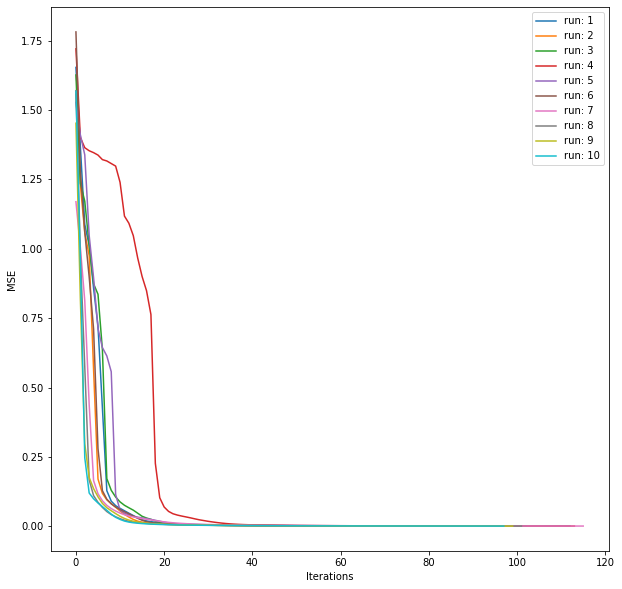

In [308]:
plt.figure(figsize = (10,10))
for i in range(mse_mlp.shape[1]):
    x = np.arange(0,mse_mlp.shape[0],1)
    plt.plot(x,mse_mlp.iloc[:,i], label='run: '+np.str(i+1))
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend(loc='best')

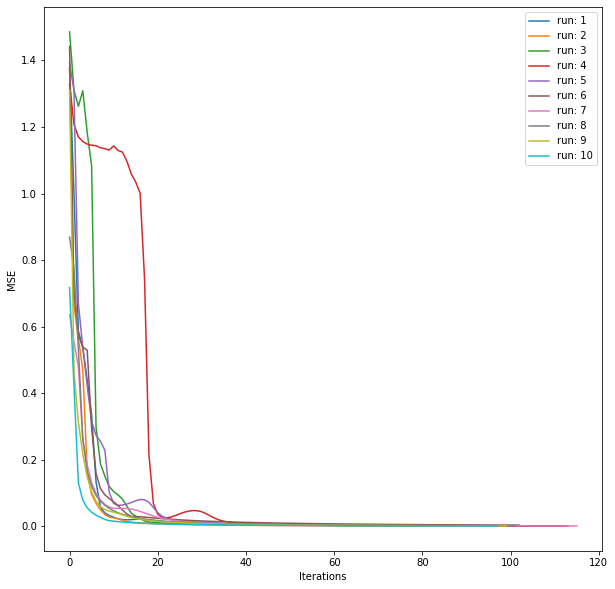

In [309]:
plt.figure(figsize = (10,10))
for i in range(mseval_mlp.shape[1]):
    x = np.arange(0,mseval_mlp.shape[0],1)
    plt.plot(x,mseval_mlp.iloc[:,i], label='run: '+np.str(i+1))
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend(loc='best')

In [310]:
msemin   = mseval_mlp.min().min()
minval   = mseval_mlp.iloc[:,(mseval_mlp.iloc[(mseval_mlp <= msemin).values] == msemin).values[0]]
mintrain = pd.DataFrame(mse_mlp[minval.columns[0]])
index = minval[minval.values == msemin].index[0]
msemin

0.0010697211374590034

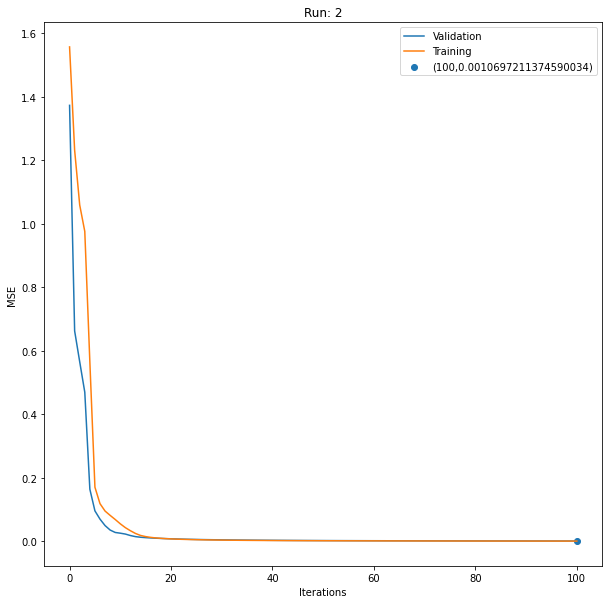

In [311]:
plt.figure(figsize = (10,10))

x = np.arange(0,minval.shape[0],1)
plt.plot(x,minval, label='Validation')
plt.plot(x,mintrain, label='Training')
plt.scatter(index,msemin)
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title('Run: '+minval.columns[0])
plt.legend(('Validation','Training','('+np.str(index)+','+np.str(msemin)+')'),loc='best')

Text(0, 0.5, 'MSE')

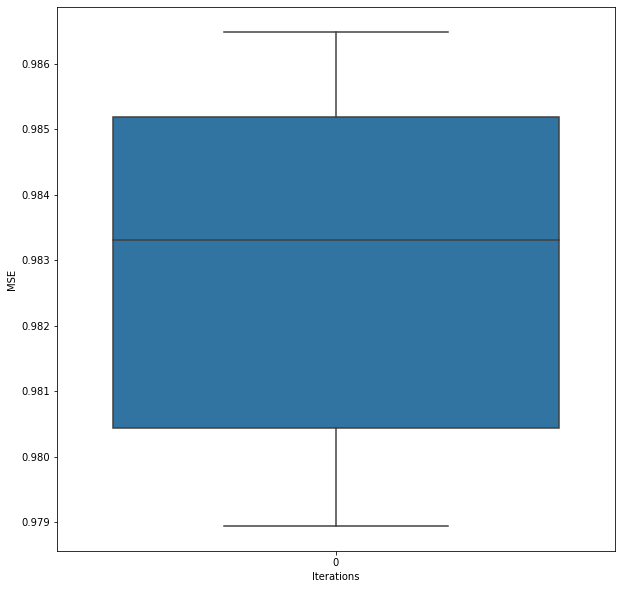

In [312]:
plt.figure(figsize = (10,10))
sns.boxplot(data=msetest_mlp)
plt.xlabel('Iterations')
plt.ylabel('MSE')